# BSAN 745: Final Project
## Grocery & Gourmet foods

*Rachel Weis, Jui Nagarkar, Rochan Peechara, Nathan Dodson*

# `>>` NOTE TO THE PROFESSOR / GRADER `<<`

The below code might be useful for you in future classes; it allows you to connect Google Drive folders to the Colab workspace so if everyone connects the same shared folder, it acts as a shared workspace.

As there is no need to run it for this assignment submission I made them markdown codeblocks, but feel free to check it out.

\- Team 3

# Connect to Google Drive

Link to shared GDrive for project stuff:

https://drive.google.com/drive/folders/1HWDCi7pBo3BlZ03lUglLLUU0cf4ie3F0?usp=sharing

Make sure to add a shortcut of the shared folder to your drive:

1. Click on the above link to get access to the project folder.
2. Go to "Shared with Me" in GDrive and find the Folder - create a shortcut to the root of your GDrive by dragging and dropping it to your home folder.
3. Run the GDrive `drive.mount` function below, and give Google access in the new window.
4. Make sure everything worked properly by running `!ls ...` command below, then `%cd ...`
5. Profit!

Run this to connect to GDrive

```python
from google.colab import drive
drive.mount('/content/drive')
```

After you've accessed the shared folder, make sure to add a shortcut to your drive at this point.

Then, run the following to test that the folder is actually there:

```python
!ls '/content/drive/MyDrive/BSAN 745 - Group Project'
```

Finally, set the project working directory into the folder:

```python
%cd '/content/drive/MyDrive/BSAN 745 - Group Project'
```

In [ ]:
# show warnings just once to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Subset Step

We begin the analysis with subsetting the data so our python notebooks can handle the models more easily.

In [ ]:
import pandas as pd

data_file = "grocery.gz"
subset_out_file = "grocery_subset.csv"
n_samples = 50000

full_df = pd.read_json(data_file, compression="gzip", lines=True)
full_df["help votes"] = full_df['helpful'].str.get(0)
full_df["tot votes"] = full_df['helpful'].str.get(1)

subset_df = full_df[full_df["tot votes"] > 0].copy()
subset_df["prop help"] = subset_df["help votes"] / subset_df["tot votes"]
subset_df.drop(columns="helpful", inplace=True)

# after initial processing, we still have too many (> 50000) observations
print("Inital Subset Shape: {}".format(subset_df.shape))

# finish subset
subset_df = subset_df.sample(n=n_samples, random_state=42)
print("Final Subset Shape: {}".format(subset_df.shape))

##########
# uncomment the next line to regenerate subset file
##########

subset_df.to_csv(subset_out_file,index=False)

Inital Subset Shape: (64851, 11)
Final Subset Shape: (50000, 11)


Per the guidance on the project PDF;

> You will use the `reviewText` column as the **text data** for your project.
Three outcome columns of interest: `tot votes`, `help votes`, and `prop help`
The column `tot votes` represents the total number of votes the review received. The `help votes` column is the total number of helpful votes each review received. The `prop help` is the number of “help votes” divided by “tot votes” and therefore represents the percentage (proportion) of votes that were helpful.

Separating out the useful columns that we want and creating a dataframe from them:

In [ ]:
# reviewText = text data
# tot votes = total votes recieved by the review
# help votes = total 'helpful' votes a review recieved
# prop help = help votes / total votes

useful_columns = subset_df[['reviewText', 'tot votes', 'help votes', 'prop help']]
useful_df = pd.DataFrame(useful_columns)

In [ ]:
# print(useful_df) # `prop help` is target variable

# 'Helpfulness' Distribution

Below, you can see a histogram of the distribution of the proportion of helpfulness corresponding to the reviews in the dataset.

This was helpful for us to pick a threshold for what is considered 'helpful' and what is not, specifically for our category labels below.

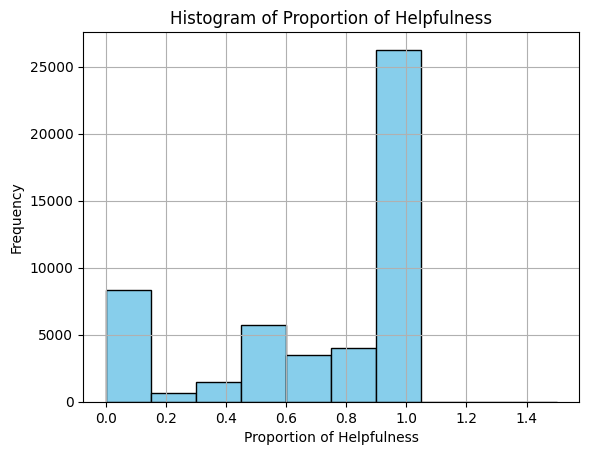

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(useful_df['prop help'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Proportion of Helpfulness')
plt.ylabel('Frequency')
plt.title('Histogram of Proportion of Helpfulness')
plt.grid(True)
plt.show()

# Categorizing the Dataset

> a. Design a method to assign a categorical label (“Useful”/”Not Useful”) to
each review based on the proportion/percentage of helpful votes received.
You can come up with any design you'd like as long as it makes sense. You
may also choose to use several cutoff values for “Useful/Not useful” and to
then conduct your project using each.

Creates a categorical column of useful/not useful (called `usefullness`) based on the `prop help` proportion column.

If prop help ratio is greater than some `threshold`, then it is categorized as useful.

In [ ]:
threshold = 0.50

def usefulness(prop_val):
    if prop_val > threshold:
        return 'useful'
    else:
        return 'not useful'

useful_df['usefulness'] = useful_df['prop help'].apply(usefulness)

useful_subset = useful_df[useful_df['usefulness'] == 'useful']
not_useful_subset = useful_df[useful_df['usefulness'] == 'not useful']

> b. Create a DTM with appropriate preprocessing steps (stopword removal stemming, n-gram tokenization, etc.) or processed sequences (if you’re planning to try a deep learning model).

Now, we will create our DTM with the appropriate preprocessing steps

In [ ]:
# start by getting the documents and the labels
import pandas as pd

docs = useful_df["reviewText"]
labels = useful_df["usefulness"]


In [ ]:
# print(docs)
# print(labels)

# Sentiment Analysis Step

In [ ]:
import nltk

print("Collecting lexicon...")

if nltk.download('vader_lexicon', quiet=True):
	print("Done.")

Done.


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

print("Building scores...")

mytext= useful_df['reviewText']
sia = SentimentIntensityAnalyzer()
scores_alltext = []
for t in mytext:
  scores_alltext.append(sia.polarity_scores(t))
# print(scores_alltext[:15])

from nltk.sentiment import SentimentIntensityAnalyzer
mytextuseful= useful_subset['reviewText']
sia = SentimentIntensityAnalyzer()
scores_useful = []
for t in mytextuseful:
  scores_useful.append(sia.polarity_scores(t))
# print(scores_useful[:15])

from nltk.sentiment import SentimentIntensityAnalyzer
mytextnotuseful= not_useful_subset['reviewText']
sia = SentimentIntensityAnalyzer()
scores_notuseful = []
for t in mytextnotuseful:
  scores_notuseful.append(sia.polarity_scores(t))
# print(scores_notuseful[:15])

Building scores...


In [ ]:
print("Gathering scores and calculating statistics...")

scores_all = [sia.polarity_scores(t)['compound'] for t in mytext]
scores_useful = [sia.polarity_scores(t)['compound'] for t in mytextuseful]
scores_notuseful = [sia.polarity_scores(t)['compound'] for t in mytextnotuseful]

avg_all = sum(scores_all) / len(scores_all)
avg_useful = sum(scores_useful) / len(scores_useful)
avg_notuseful = sum(scores_notuseful) / len(scores_notuseful)

print("Mean, Total: {}\nMean, Useful: {}f\nMean, Not Useful: {}".format(avg_all, avg_useful, avg_notuseful))

Gathering scores and calculating statistics...


In [ ]:
# !pip install NRCLex
print("Collecting punkt...")
if nltk.download('punkt', quiet=True):
    print("Done.")

Done.


In [ ]:
from nrclex import NRCLex
import json
import textwrap

print("Total Reviews: \nBuilding emotion scores and affect frequencies...")

myemoText = mytext[:15]
for t in myemoText:
  emotion = NRCLex(t)
  print("---")
  print(textwrap.fill(t, 120))
  print(json.dumps(emotion.raw_emotion_scores, indent=2))
  print(json.dumps(emotion.affect_frequencies, indent=2))

print("Done.")

Total Reviews: 
Building emotion scores and affect frequencies...
---
I have updated this mixed review due to the currently outrageous high shipping does NOT justify this product's value.
Although This is the best gluten free sour dough bread I have sampled thus far it is much too expensive to pay upwards
to $30 for 3 loaves.  I have shipped baked goods to military family priority mail for a flat rate of under ten bucks in
the past.Company states they will reduce shipping charges in the future but that doesn't help me or others currently
eager for this product.As for the quality/consistency of this bread, It is fluffy compared to ther bakeries and has not
molded after 10 days.  It toasts well and easily makes grilled sandwiches delicious.  The nutritional content is as
follows :  1 slice is 140 calories, no saturated or trans fats, total fat 2 grams.  Cholesterol 20 mg, sodium 190 mg,
total carb ( for one huge slice ) is 29 grams, fiber 1 gram , sugars 1 gram , protein 2 grams.  This h

In [ ]:
print("Useful Reviews:\nBuilding emotion scores and affect frequencies...")

myemoText = mytextuseful[:15]
for t in myemoText:
  emotion = NRCLex(t)
  print("---")
  print(textwrap.fill(t, 120))
  print(json.dumps(emotion.raw_emotion_scores, indent=2))
  print(json.dumps(emotion.affect_frequencies, indent=2))

print("Done.")


Useful Reviews:
Building emotion scores and affect frequencies...
---
I have updated this mixed review due to the currently outrageous high shipping does NOT justify this product's value.
Although This is the best gluten free sour dough bread I have sampled thus far it is much too expensive to pay upwards
to $30 for 3 loaves.  I have shipped baked goods to military family priority mail for a flat rate of under ten bucks in
the past.Company states they will reduce shipping charges in the future but that doesn't help me or others currently
eager for this product.As for the quality/consistency of this bread, It is fluffy compared to ther bakeries and has not
molded after 10 days.  It toasts well and easily makes grilled sandwiches delicious.  The nutritional content is as
follows :  1 slice is 140 calories, no saturated or trans fats, total fat 2 grams.  Cholesterol 20 mg, sodium 190 mg,
total carb ( for one huge slice ) is 29 grams, fiber 1 gram , sugars 1 gram , protein 2 grams.  This h

In [ ]:
print("Not Useful Reviews:\nBuilding emotion scores and affect frequencies...")

myemoText = mytextnotuseful[:15]
for t in myemoText:
  emotion = NRCLex(t)
  print("---")
  print(textwrap.fill(t, 120))
  print(json.dumps(emotion.raw_emotion_scores, indent=2))
  print(json.dumps(emotion.affect_frequencies, indent=2))

print("Done.")

Not Useful Reviews:
Building emotion scores and affect frequencies...
---
I'm sorry to say that I just wasn't that impressed with this infused water. For the price I could have bought 2 cases of
bottled water and a watermelon and made my own and got at least 3 times as much. I hate to quibble about price because
the vendor can charge whatever they want so I didn't take away any stars for cost. I'm only mentioning it because it's
pertinent. I gave this 2 stars purely because you can hardly taste the watermelon and I've made my own infused water
before and it generally has more flavor and also because I really like the bottles this stuff comes in - they have a
much wider neck than most bottled water comes in so it'll be easy to place chunks of fruit in them and even ice cubes
and so long as your fruit isn't in huge pieces you should be able to get it back out fairly easily. I'm happy to have
12, 16 ounce bottles that I can use for my own concoctions, so not a total loss.For those that li

# Preproccessing Step

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from string import punctuation, digits
import re

ps = PorterStemmer()

def preprocess_text(text):
  text = text.lower() # lowercase
  text = text.translate(str.maketrans('', '', digits)) # remove numbers
  text = text.translate(str.maketrans('', '', punctuation)) # remove punctuation
  text = re.sub(' +', ' ',text).strip() # remove extra spaces, and spaces at the beginning and end of the string
  t_list = text.split(" ")
  text = " ".join(ps.stem(word) for word in t_list)
  return text

extra_words = ["like", "use", "nice", "dont", "ive", "im", "better", "think", "lot"]
stopwords = list(ENGLISH_STOP_WORDS)
stopwords.sort()
mystopwords = stopwords + extra_words
stem_stopwords = [ps.stem(word) for word in mystopwords]

tv = TfidfVectorizer(preprocessor=preprocess_text,
                     stop_words=stem_stopwords,
                     norm=None,
                     smooth_idf=False,
                     max_df=docs.shape[0] - 1,
                     min_df=2,
                     max_features=1000)

dtm = tv.fit_transform(docs)
print(dtm)

  (0, 199)	4.482190540871687
  (0, 975)	4.56277557731821
  (0, 332)	2.0640369640284195
  (0, 380)	2.4300372840678097
  (0, 685)	4.213390894637631
  (0, 867)	3.122432553484931
  (0, 319)	4.318696160150411
  (0, 427)	4.8509279060683355
  (0, 128)	4.869921829409511
  (0, 811)	4.5691427725116025
  (0, 539)	10.095685457141363
  (0, 161)	5.714985051995298
  (0, 377)	23.848278820706117
  (0, 917)	9.344438026441658
  (0, 314)	7.931570394372078
  (0, 755)	5.607172188658764
  (0, 123)	3.529485693185968
  (0, 798)	10.497790644141398
  (0, 336)	4.938366980767748
  (0, 191)	4.590664406616981
  (0, 578)	4.384930409198283
  (0, 237)	3.4301912175991918
  (0, 752)	5.250296863995987
  (0, 521)	2.371602812376901
  (0, 279)	4.6253414333099485
  :	:
  (49999, 124)	4.340478646627449
  (49999, 360)	10.394083920920886
  (49999, 909)	5.908981640369756
  (49999, 679)	3.850420542393937
  (49999, 234)	8.735912095764707
  (49999, 192)	5.025191703533784
  (49999, 587)	5.44645849483327
  (49999, 23)	4.80048163069523

In [ ]:
import numpy as np
pos_inds = np.where(labels == "useful")[0]
full_inds = [i for i in range(dtm.shape[0])]
neg_inds = list(set(full_inds) - set(pos_inds))
pos_dtm = dtm[pos_inds]
neg_dtm = dtm[neg_inds]
print("Useful DTM: {}".format(pos_dtm.shape))
print("Not Useful DTM: {}".format(neg_dtm.shape))
print("Total Reviews DTM: {}".format(dtm.shape))

Useful DTM: (34043, 1000)
Not Useful DTM: (15957, 1000)
Total Reviews DTM: (50000, 1000)


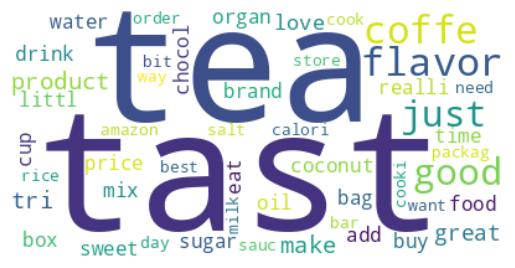

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

terms = tv.get_feature_names_out()
freq_sum = pos_dtm.sum(axis=0)[0].tolist()[0] # this creates a list within a list so we select the first element

#tf_dict1
tf_dict1 = dict(zip(terms,freq_sum))
wordcld = WordCloud(background_color="white", max_words=50,random_state=15)
wordcld.generate_from_frequencies(tf_dict1)
# show
plt.imshow(wordcld, interpolation="bilinear")
plt.axis("off")
plt.show()

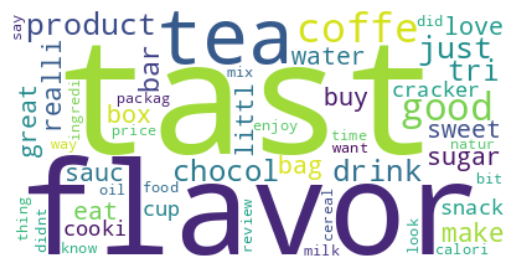

In [ ]:
terms = tv.get_feature_names_out()
freq_sum = neg_dtm.sum(axis=0)[0].tolist()[0] # this creates a list within a list so we select the first element

# tf_dict1
tf_dict1 = dict(zip(terms,freq_sum))
wordcld = WordCloud(background_color="white", max_words=50,random_state=15)
wordcld.generate_from_frequencies(tf_dict1)
# show
plt.imshow(wordcld, interpolation="bilinear")
plt.axis("off")
plt.show()

# Training / Testing Split

Now we will split into training and testing for model building and validation purposes

In [ ]:
# ref: https://colab.research.google.com/drive/1B1ej5OxrjGaMvCuTNH0wh_G9tvNhVVso?usp=share_link#scrollTo=KeCWc3RsuYDN

#
# Uncomment to regenerate .pkl file!
#
from sklearn.model_selection import train_test_split
import numpy as np

# covert labels to binary
num_labels = labels.replace(["not useful","useful"],[0,1])

# convert to matrix
dtm_df = pd.DataFrame(dtm.toarray(),columns=tv.get_feature_names_out())

# train-test split using indices
# 80% topic cutoff
cutoff = 0.8
train_ind = np.random.choice(dtm_df.shape[0],round(dtm_df.shape[0] * cutoff),replace=False)
test_ind = list(set([i for i in range(dtm_df.shape[0])]) - set(train_ind))
X_train = dtm_df.iloc[train_ind]
X_test = dtm_df.iloc[test_ind]
y_train = np.array(num_labels)[train_ind]
y_test = np.array(num_labels)[test_ind]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(dtm_df, num_labels,
                                                    test_size=0.2,
                                                    random_state=43)

print("Training split (80%): {}".format(X_train.shape))
print("Testing split (20%): {}".format(X_test.shape))
# end uncomment

Training split (80%): (40000, 1000)
Testing split (20%): (10000, 1000)


# Generate `.pkl` File

In [ ]:
#
# INFO: MUST RUN THIS CODE BLOCK BEFORE RUNNING MODELS!
#

# ref: week 7 text classification lecture
import pickle as pkl

#
# Uncomment to regenerate .pkl file
#
with open("indicies.pkl",'wb') as outfile:
  pkl.dump({ "X_train":X_train, "y_train":y_train, "X_test":X_test, "y_test":y_test}, outfile)
# end uncomment

# changed our other models to use the .pkl file that is generated above
with open("indicies.pkl",'rb') as infile:
  indicies = pkl.load(infile)

# Logistic Regression

Optimization terminated successfully.
         Current function value: 0.569133
         Iterations 8


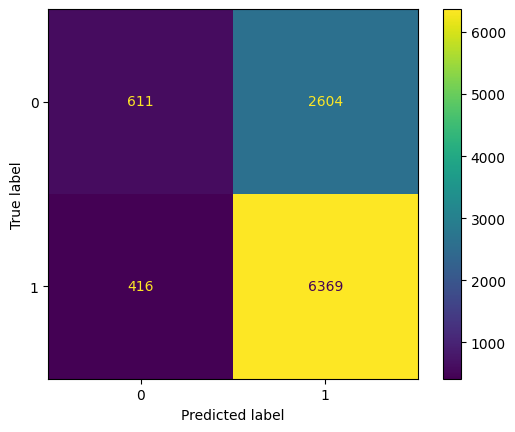

In [ ]:
# (Logistic Regression) model training: statsmodels
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

X_train_sm = sm.add_constant(indicies['X_train'])
X_test_sm = sm.add_constant(indicies['X_test'])

log_reg = sm.Logit(list(indicies['y_train']), X_train_sm, method='bfgs').fit()

# create prediction (statsmodel API)
lr_pred = log_reg.predict(X_test_sm).round()

# recall: not useful = 0, useful = 1
lr_contable = confusion_matrix(list(indicies['y_test']),lr_pred, labels=[0,1])
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_contable,
                             	display_labels=[0,1])


tn, fp, fn, tp = lr_contable.ravel()
lr_acc = (lr_contable[0,0] + lr_contable[1,1]) / np.sum(lr_contable)
lr_auc = roc_auc_score(indicies['y_test'], lr_pred)
lr_spec = tn / (tn + fp)
lr_sens = tp / (tp + fn)

# uncomment to display plot
lr_disp.plot()

#  KNN Classifier

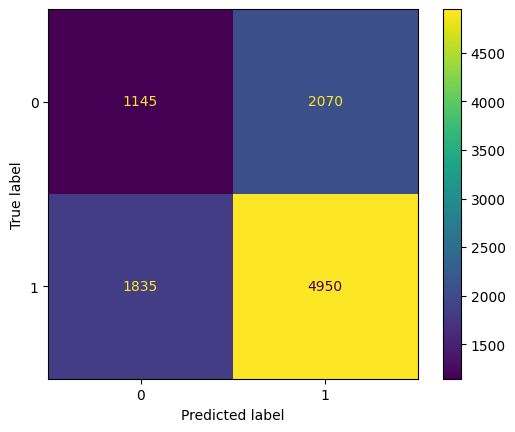

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# K-Nearest Neighbors Model Initialization and Training
kNN = KNeighborsClassifier(n_neighbors=3)
kNN.fit(indicies['X_train'], indicies['y_train'])

# Model Prediction
knn_pred = kNN.predict(indicies['X_test'])

# Model Evaluation: Confusion Matrix and Accuracy
knn_contable = confusion_matrix(indicies['y_test'], knn_pred, labels=[0, 1])
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_contable, display_labels=["0", "1"])
knn_disp.plot()

# Calculating Stats
tn, fp, fn, tp = knn_contable.ravel()
knn_acc = np.sum(knn_pred == indicies['y_test']) / len(knn_pred)
knn_auc = roc_auc_score(indicies['y_test'], knn_pred)
knn_spec = tn / (tn + fp)
knn_sens = tp / (tp + fn)

# Optionally: Display the Confusion Matrix Plot
plt.show()

#  Decision Tree Classifier

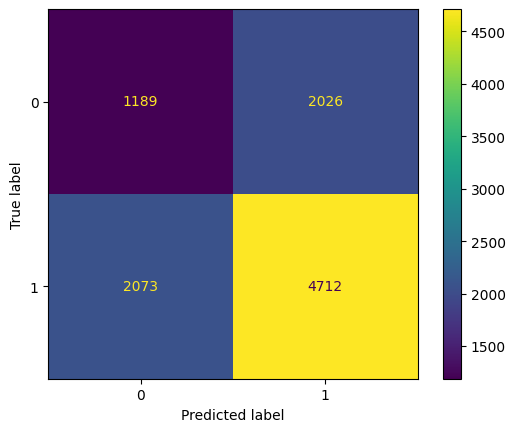

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier with a random state for reproducibility
dt = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt.fit(indicies['X_train'], indicies['y_train'])

# Make predictions on the test data
dt_pred = dt.predict(indicies['X_test'])

# Create a confusion matrix
dt_contable = confusion_matrix(indicies['y_test'], dt_pred, labels=[0, 1])
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_contable, display_labels=["0", "1"])

# Plot the confusion matrix
dt_disp.plot()

# Calculating Stats
tn, fp, fn, tp = dt_contable.ravel()
dt_acc = np.sum(dt_pred == indicies['y_test']) / len(dt_pred)
dt_auc = roc_auc_score(indicies['y_test'], dt_pred)
dt_spec = tn / (tn + fp)
dt_sens = tp / (tp + fn)

# Display the plot
plt.show()


In [ ]:
from sklearn.tree import plot_tree

# Fit the model to the training data
dt.fit(indicies['X_train'], indicies['y_train'])

# Visualize the decision tree
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(dt, filled=True, feature_names=indicies['X_train'].columns, class_names=['0', '1'])

# commical to show but here it is nonetheless...
plt.show()

# Compile Diagnostics

In [ ]:
import tabulate

table = [["Log Regression", lr_acc, lr_auc, lr_sens, lr_spec],
         ["KNN Classifier", knn_acc, knn_auc, knn_sens, knn_spec],
         ["Decision Tree", dt_acc, dt_auc, dt_sens, dt_spec]]

print(tabulate.tabulate(table, headers=["Accuracy","AUC", "Sensitivity", "Spec"]))

                  Accuracy       AUC    Sensitivity      Spec
--------------  ----------  --------  -------------  --------
Log Regression      0.698   0.564367       0.938688  0.190047
KNN Classifier      0.6095  0.542847       0.72955   0.356143
Decision Tree       0.5901  0.532151       0.694473  0.369829
